# GitHub Developer Graph Classification Analysis

## 1. Imports and Setup

In [29]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
%matplotlib inline

## 2. Load Data (from dictionary-format JSON)

In [30]:
# Load the JSON file
with open('D:/GraphMining/GraphMining/git_edges.json', 'r') as f:
    full_data = json.load(f)

# Sort keys and extract edge lists
sorted_keys = sorted(full_data.keys(), key=int)
edge_lists = [full_data[k] for k in sorted_keys[:100]]

# Load the CSV file with the correct path
targets_df = pd.read_csv('D:/GraphMining/GraphMining/git_target.csv', index_col=0)

# Extract labels
labels = [targets_df.loc[int(k), "target"] for k in sorted_keys[:100]]

print(f"Loaded {len(edge_lists)} graphs")
print("Example graph:", edge_lists[0][:5])

Loaded 100 graphs
Example graph: [[0, 16], [1, 16], [2, 16], [3, 16], [3, 19]]


## 3. Convert to NetworkX Graphs

In [31]:
graphs = []
for edges in tqdm(edge_lists):
    G = nx.Graph()
    valid_edges = [tuple(e) for e in edges if len(e) >= 2]
    G.add_edges_from(valid_edges)
    graphs.append(G)

print(f"First graph: {graphs[0].number_of_nodes()} nodes, {graphs[0].number_of_edges()} edges")

100%|██████████| 100/100 [00:00<00:00, 1286.71it/s]

First graph: 71 nodes, 78 edges


## 4. Dataset Statistics

In [32]:
num_nodes = [g.number_of_nodes() for g in graphs]
num_edges = [g.number_of_edges() for g in graphs]
densities = [nx.density(g) for g in graphs]

print("# Nodes:", np.min(num_nodes), "to", np.max(num_nodes))
print("# Edges:", np.min(num_edges), "to", np.max(num_edges))
print("Density:", round(np.mean(densities), 4))

label_counts = pd.Series(labels).value_counts()
print("\nLabel distribution:")
print(label_counts)

# Nodes: 10 to 815
# Edges: 10 to 1969
Density: 0.0765

Label distribution:
0    52
1    48
dtype: int64


## 5. Visualize Sample Graphs


Sample graphs for label 0:


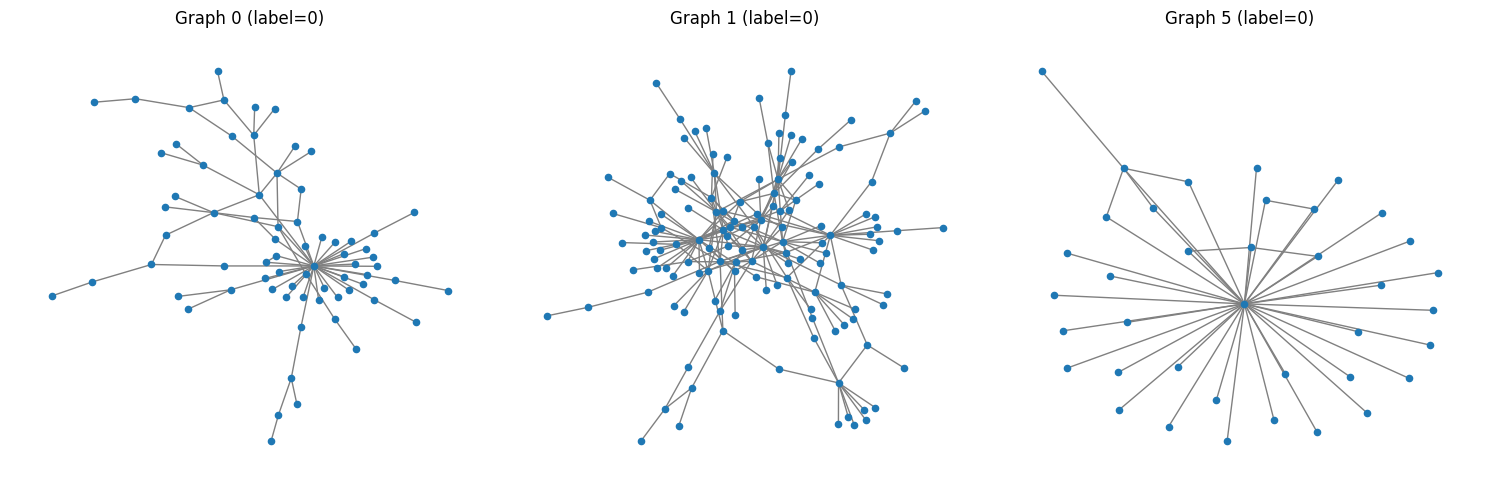


Sample graphs for label 1:


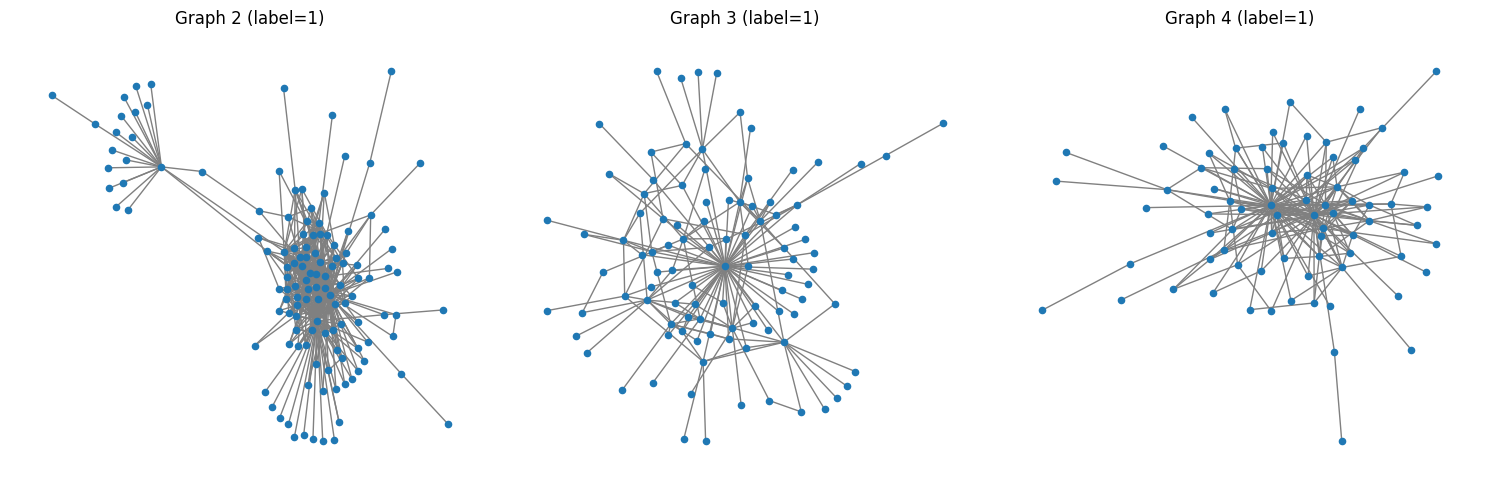

In [33]:
def plot_graph(g, ax, title):
    pos = nx.spring_layout(g, seed=42)
    nx.draw(g, pos, node_size=20, edge_color='gray', ax=ax)
    ax.set_title(title)
    ax.axis('off')

# Show 3 graphs from each class in a subplot layout
for label in [0, 1]:
    print(f"\nSample graphs for label {label}:")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    count = 0
    for i, g in enumerate(graphs):
        if labels[i] == label:
            plot_graph(g, axes[count], f"Graph {i} (label={label})")
            count += 1
            if count == 3:
                break
    plt.tight_layout()
    plt.show()


## 6. Graph Centralities & Community Detection (Detailed Experiments)

In [34]:
# Pick a single graph
sample_index = 0
sample_graph = graphs[sample_index]
print(f"Graph {sample_index} has {sample_graph.number_of_nodes()} nodes, {sample_graph.number_of_edges()} edges.")

# Compute centralities
degree_centrality = nx.degree_centrality(sample_graph)
between_centrality = nx.betweenness_centrality(sample_graph)
closeness_centrality = nx.closeness_centrality(sample_graph)
try:
    eigen_centrality = nx.eigenvector_centrality(sample_graph)
except:
    eigen_centrality = None

# Sort by degree centrality
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 by Degree Centrality:", sorted_degree[:5])
# Sort by betweenness
sorted_between = sorted(between_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 5 by Betweenness Centrality:", sorted_between[:5])
# Sort by closeness
sorted_close = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 5 by Closeness Centrality:", sorted_close[:5])

if eigen_centrality:
    sorted_eigen = sorted(eigen_centrality.items(), key=lambda x: x[1], reverse=True)
    print("Top 5 by Eigenvector Centrality:", sorted_eigen[:5])

Graph 0 has 71 nodes, 78 edges.

Top 5 by Degree Centrality: [(16, 0.4857142857142857), (20, 0.08571428571428572), (22, 0.08571428571428572), (42, 0.07142857142857142), (8, 0.05714285714285714)]
Top 5 by Betweenness Centrality: [(16, 0.8332643202208421), (42, 0.31269841269841275), (8, 0.17429261559696335), (22, 0.14440993788819884), (12, 0.1282608695652174)]
Top 5 by Closeness Centrality: [(16, 0.5072463768115942), (42, 0.41916167664670656), (8, 0.3954802259887006), (68, 0.3645833333333333), (7, 0.35175879396984927)]
Top 5 by Eigenvector Centrality: [(16, 0.6935329234001211), (42, 0.14633363752520812), (8, 0.14151726312785287), (53, 0.14038770650589305), (58, 0.14038770650589305)]


### 6.1 Community Detection
Using the Girvan-Newman algorithm 

Girvan-Newman split (first level): [39, 32]


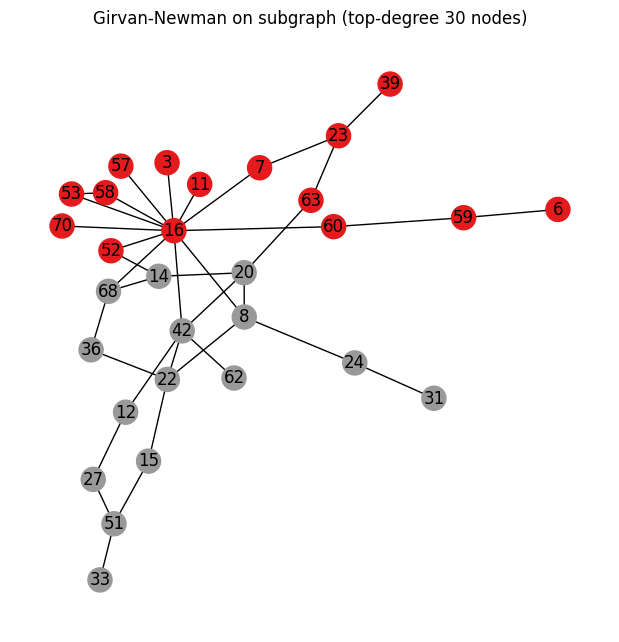

In [35]:
from networkx.algorithms import community

# We'll compute just the first few levels of the Girvan-Newman tree
gn_gen = community.girvan_newman(sample_graph)
# Get the first level partition
first_level_communities = next(gn_gen)
print("Girvan-Newman split (first level):", [len(c) for c in first_level_communities])

# Visualize these communities in a small subgraph
# If the graph is large, let's pick just the subgraph of the biggest 30 nodes by degree
big_nodes = [n for n, deg in sorted(sample_graph.degree, key=lambda x: x[1], reverse=True)[:30]]
subg = sample_graph.subgraph(big_nodes)

# We run girvan-newman on the subg for a simpler view
subg_gn = community.girvan_newman(subg)
subg_first = next(subg_gn)
list_communities = list(subg_first)

# Assign colors
community_map = {}
for i, cset in enumerate(list_communities):
    for node in cset:
        community_map[node] = i

pos = nx.spring_layout(subg, seed=42)
colors = [community_map[n] for n in subg.nodes()]
plt.figure(figsize=(6, 6))
nx.draw(subg, pos, node_color=colors, with_labels=True, cmap=plt.cm.Set1)
plt.title("Girvan-Newman on subgraph (top-degree 30 nodes)")
plt.show()

## 7. Spectral vs. Node2Vec Embeddings

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 594.10it/s]


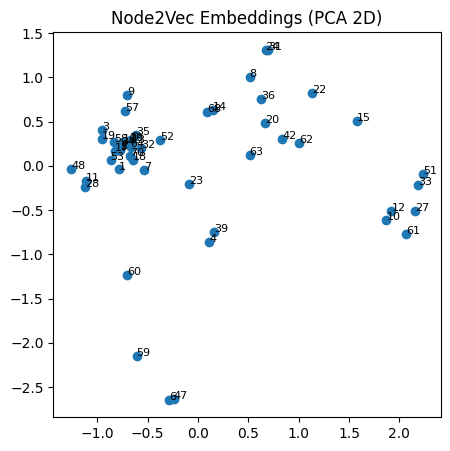

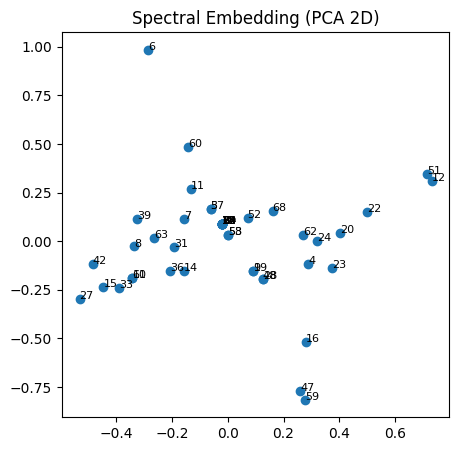

In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from node2vec import Node2Vec

# Subgraph with top 50 nodes by degree for clarity
big_nodes_50 = [n for n, deg in sorted(sample_graph.degree, key=lambda x: x[1], reverse=True)[:50]]
g_sub = sample_graph.subgraph(big_nodes_50).copy()

# 10.1 Node2Vec Embedding
try:
    node2vec_model = Node2Vec(g_sub, dimensions=16, walk_length=10, num_walks=50, workers=1)
    n2v = node2vec_model.fit(window=5, min_count=1)

    # Build embedding array
    emb_array = []
    node_list = list(g_sub.nodes())
    for node in node_list:
        # node2vec model expects string keys
        if str(node) in n2v.wv:
            emb_array.append(n2v.wv[str(node)])
        else:
            emb_array.append(np.zeros(16))
    emb_array = np.array(emb_array)

    # 2D projection via PCA
    pca_2d = PCA(n_components=2)
    node2vec_2d = pca_2d.fit_transform(emb_array)

    plt.figure(figsize=(5, 5))
    plt.scatter(node2vec_2d[:, 0], node2vec_2d[:, 1])
    for i, node in enumerate(node_list):
        plt.text(node2vec_2d[i, 0], node2vec_2d[i, 1], str(node), fontsize=8)
    plt.title("Node2Vec Embeddings (PCA 2D)")
    plt.show()

except ImportError:
    print("Please install node2vec via pip install node2vec")

# 10.2 Spectral Embedding
# We'll compute the normalized Laplacian and do an eigen-decomposition
lap = nx.normalized_laplacian_matrix(g_sub)

# Since g_sub might not be fully connected, we might only get partial rank
# We'll do PCA on the laplacian anyway for comparison
lapdense = lap.todense()

pca_spec = PCA(n_components=2)
spectral_2d = pca_spec.fit_transform(lapdense)

plt.figure(figsize=(5, 5))
plt.scatter(spectral_2d[:, 0], spectral_2d[:, 1])
for i, node in enumerate(g_sub.nodes()):
    plt.text(spectral_2d[i, 0], spectral_2d[i, 1], str(node), fontsize=8)
plt.title("Spectral Embedding (PCA 2D)")
plt.show()
